In [8]:
# %matplotlib notebook
%matplotlib inline
from ipynb_setup import *
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

import os
import re
from pathlib import Path
from IPython.display import Markdown, display

from dataframe import get_experiments_matching, create_experiment_df, preprocess_df
from utils.pandas import filter_dataframe
from plot import DATASETS, MATCH_PATTERNS, VALUE_DICT, QUERYMETHODS, get_label_regime

import utils.eval as evaluate
from utils.eval import compute_pairwise_matrix
from plotlib.performance_plots import plot_pairwise_matrix

In [14]:
base_path = Path("/mnt/drive_nvme2/logs_cluster/activelearning")
base_path2 = Path("/mnt/drive_nvme2/logs_cluster/activelearning_balanced/")
save_path = Path("./plots")
# df = create_experiment_df(base_path, DATASETS, rewrite=True)

# df = pd.concat([df, create_experiment_df(base_path2, DATASETS, rewrite=True)], axis=0)

df = create_experiment_df(base_path2, DATASETS, rewrite=True)
filter_ = get_experiments_matching(df, key="Rel. Path", patterns=[".*batchbald.*", ".*low_data.*", ".*_imbalance.*"])
df = df[~filter_]

df = preprocess_df(df, MATCH_PATTERNS, VALUE_DICT)
inv_dataset = {v: k for k, v in DATASETS.items()}

df["Dataset"] = df["Dataset"].map(inv_dataset)
df["Label Regime"] = df["Label Regime"].map(get_label_regime)
df["Query Method"] = df["Query Method"].map(QUERYMETHODS)

df = df[df["Label Regime"].isin(["med", "high", "low"])]
df.columns

Index(['index', 'val_acc', 'test_acc', 'num_samples', 'Acquisition Entropy',
       'Dataset Entropy', 'version', 'Name', 'Path', 'test/loss', 'test/acc',
       'Rel. Path', 'Dataset', 'Label Regime', 'Experiment Name',
       'Query Method', 'Self-SL', 'Semi-SL', 'Training'],
      dtype='object')

In [15]:
df

index  val_acc  test_acc  num_samples  Acquisition Entropy  \
0         0   0.7600    0.7186           50             2.255402   
1         1   0.7720    0.7610          100             2.159437   
2         2   0.8160    0.7996          150             2.224229   
3         3   0.8080    0.8077          200             2.205004   
4         4   0.8320    0.8129          250             2.259429   
...     ...      ...       ...          ...                  ...   
3029      3   0.7056    0.6872         2500             1.468569   
3030      0   0.7264    0.7243          250             2.184850   
3031      1   0.7608    0.7735         1000             2.011960   
3032      2   0.7800    0.7827         1750             1.796790   
3033      3   0.7688    0.7771         2498             1.662922   

      Dataset Entropy  version  \
0                 NaN        9   
1            2.255402        9   
2            2.270475        9   
3            2.296807        9   
4            2.296499        9   
...               ...      ...   
3029         1.930511        3   
3030              NaN        3   
3031         2.184850        3   
3032         2.133486        3   
3033         2.053370        3   

                                                   Name  \
0     basic-pretrained_model-resnet_drop-0_aug-cifar...   
1     basic-pretrained_model-resnet_drop-0_aug-cifar...   
2     basic-pretrained_model-resnet_drop-0_aug-cifar...   
3     basic-pretrained_model-resnet_drop-0_aug-cifar...   
4     basic-pretrained_model-resnet_drop-0_aug-cifar...   
...                                                 ...   
3029  fixmatch_model-resnet_drop-0_aug-cifar_basic_a...   
3030  fixmatch_model-resnet_drop-0_aug-cifar_basic_a...   
3031  fixmatch_model-resnet_drop-0_aug-cifar_basic_a...   
3032  fixmatch_model-resnet_drop-0_aug-cifar_basic_a...   
3033  fixmatch_model-resnet_drop-0_aug-cifar_basic_a...   

                                                   Path  test/loss  test/acc  \
0     /mnt/drive_nvme2/logs_cluster/activelearning/c...        NaN       NaN   
1     /mnt/drive_nvme2/logs_cluster/activelearning/c...        NaN       NaN   
2     /mnt/drive_nvme2/logs_cluster/activelearning/c...        NaN       NaN   
3     /mnt/drive_nvme2/logs_cluster/activelearning/c...        NaN       NaN   
4     /mnt/drive_nvme2/logs_cluster/activelearning/c...        NaN       NaN   
...                                                 ...        ...       ...   
3029  /mnt/drive_nvme2/logs_cluster/activelearning/c...   2.452401    0.6872   
3030  /mnt/drive_nvme2/logs_cluster/activelearning/c...   2.237622    0.7243   
3031  /mnt/drive_nvme2/logs_cluster/activelearning/c...   1.920639    0.7735   
3032  /mnt/drive_nvme2/logs_cluster/activelearning/c...   2.023831    0.7827   
3033  /mnt/drive_nvme2/logs_cluster/activelearning/c...   1.956890    0.7771   

                                              Rel. Path      Dataset  \
0     cifar10/active-cifar10_low/basic-pretrained_mo...     CIFAR-10   
1     cifar10/active-cifar10_low/basic-pretrained_mo...     CIFAR-10   
2     cifar10/active-cifar10_low/basic-pretrained_mo...     CIFAR-10   
3     cifar10/active-cifar10_low/basic-pretrained_mo...     CIFAR-10   
4     cifar10/active-cifar10_low/basic-pretrained_mo...     CIFAR-10   
...                                                 ...          ...   
3029  cifar10_imb/active-cifar10_med/fixmatch_model-...  CIFAR-10-LT   
3030  cifar10_imb/active-cifar10_med/fixmatch_model-...  CIFAR-10-LT   
3031  cifar10_imb/active-cifar10_med/fixmatch_model-...  CIFAR-10-LT   
3032  cifar10_imb/active-cifar10_med/fixmatch_model-...  CIFAR-10-LT   
3033  cifar10_imb/active-cifar10_med/fixmatch_model-...  CIFAR-10-LT   

     Label Regime                                    Experiment Name  \
0             low  basic-pretrained_model-resnet_drop-0_aug-cifar...   
1             low  basic-pretrained_model-resnet_drop-0_aug-cifar...   
2             low  basic-pret

In [16]:
settings = []
matrices = []
for setting, g in df.groupby(["Dataset", "Training", "Label Regime"]):
    settings.append(setting)
    val = "test_acc"
    if setting[0] in ["Mio-TCD", "ISIC-2019"]:
        val = "test/w_acc"
    matrices.append(compute_pairwise_matrix(g, val))

print(len(settings))

18


# Singular Plots

/home/c817h/Documents/projects/Active_Learning/activeframework/src/plotlib/performance_plots.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + [name_dict[alg] for alg in algs], fontsize=8)
/home/c817h/Documents/projects/Active_Learning/activeframework/src/plotlib/performance_plots.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0] + [name_dict[alg] for alg in algs], rotation=0, fontsize=8)


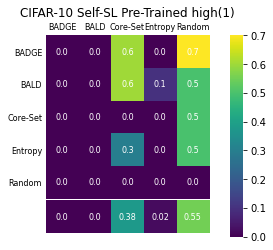

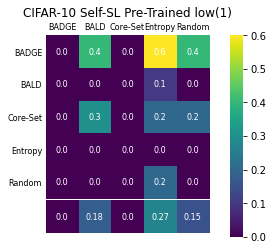

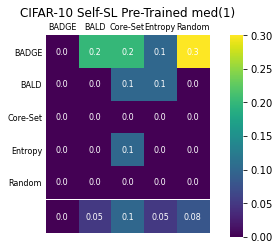

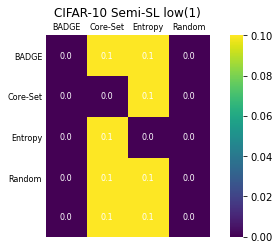

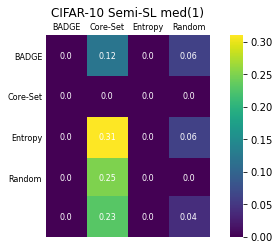

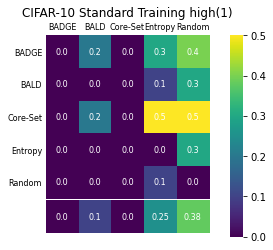

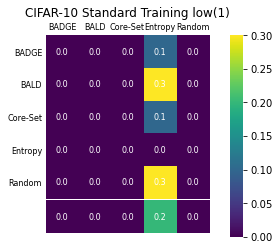

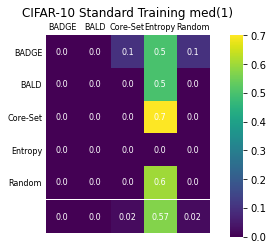

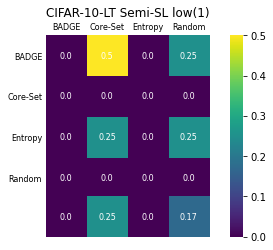

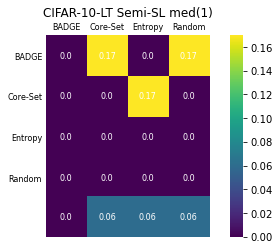

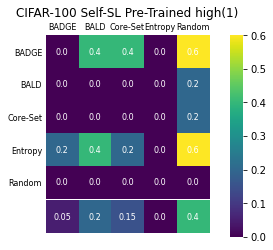

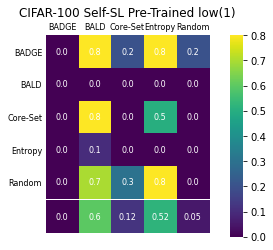

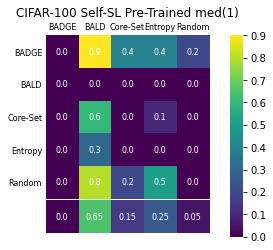

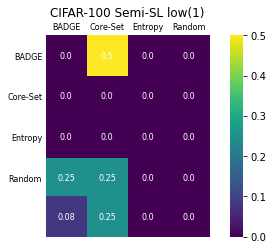

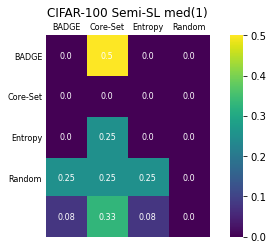

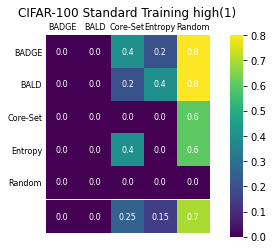

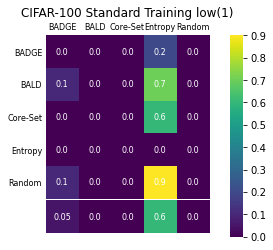

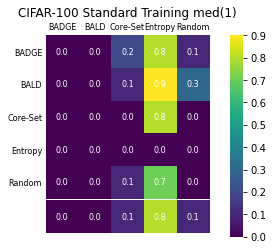

In [17]:
for i, (setting, matrix) in enumerate(zip(settings, matrices)):
    plot_setting = " ".join(setting)
    plot_pairwise_matrix(matrix, plot_setting)


## Plots for Label Regimes and Trainings

('Self-SL Pre-Trained', 'high')
('Self-SL Pre-Trained', 'low')
('Self-SL Pre-Trained', 'med')
('Semi-SL', 'low')
('Semi-SL', 'med')
('Standard Training', 'high')
('Standard Training', 'low')
('Standard Training', 'med')


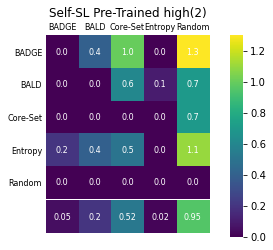

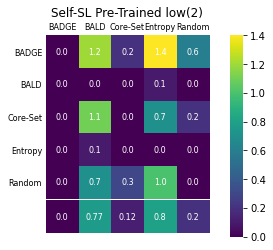

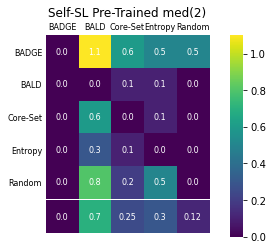

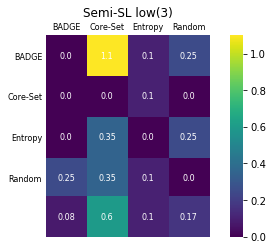

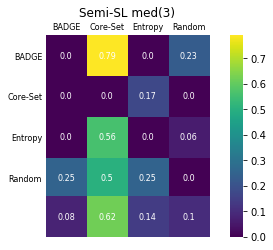

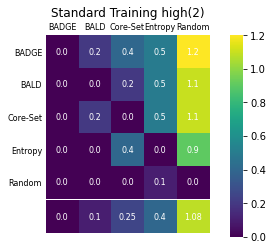

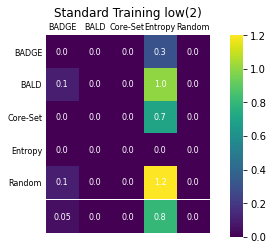

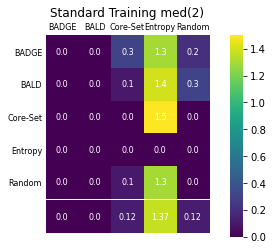

In [18]:
aggregate_list = [0]
aggregate_list.sort(reverse=True)
new_settings = dict()
for setting, matrix in zip(settings, matrices):
    new_setting = list(setting)
    for agg in aggregate_list:
        new_setting.pop(agg)
    new_setting = tuple(new_setting)
    if new_setting not in new_settings:
        new_settings[new_setting] = [matrix]
    else:
        new_settings[new_setting].append(matrix)
for setting_name, matrix_setting in new_settings.items():
    print(setting_name)
    keys = [key for key in matrix_setting[0].keys()]
    final_matrix = {}
    for k1 in keys:
        final_matrix[k1] = {}
        for k2 in keys:
            final_matrix[k1][k2]= sum([matrix[k1][k2] for matrix in matrix_setting])
    max_poss_ent = len(matrix_setting)
    plot_pairwise_matrix(final_matrix, " ".join(setting_name), max_poss_ent=max_poss_ent, show=False)

## Plots for Trainings

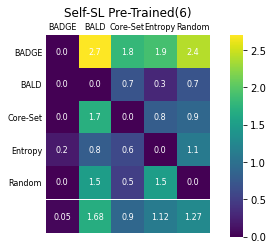

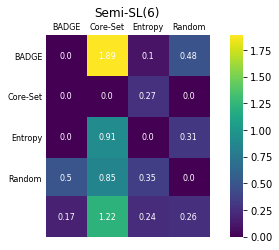

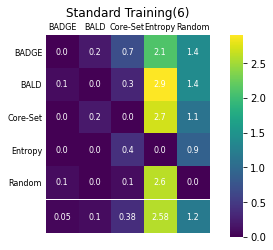

In [19]:
aggregate_list = [0,2]
aggregate_list.sort(reverse=True)
new_settings = dict()
for setting, matrix in zip(settings, matrices):
    new_setting = list(setting)
    for agg in aggregate_list:
        new_setting.pop(agg)
    new_setting = tuple(new_setting)
    if new_setting not in new_settings:
        new_settings[new_setting] = [matrix]
    else:
        new_settings[new_setting].append(matrix)
for setting_name, matrix_setting in new_settings.items():
    keys = [key for key in matrix_setting[0].keys()]
    final_matrix = {}
    for k1 in keys:
        final_matrix[k1] = {}
        for k2 in keys:
            final_matrix[k1][k2]= sum([matrix[k1][k2] for matrix in matrix_setting])
    max_poss_ent = len(matrix_setting)
    plot_pairwise_matrix(final_matrix, " ".join(setting_name), max_poss_ent=max_poss_ent)

In [ ]:
## Main Results Table

# Main Results Table

In [38]:
key = "Dataset"

def sorter(string : str):
    if re.match(".*low.*", string):
        return 0
    elif re.match(".*med.*", string):
        return 1
    elif re.match(".*high.*", string):
        return 2

aubc_dict = {}
filter = get_experiments_matching(df, "Rel. Path", [".*batchbald.*"])
df_use = df[~filter]
for dataset in df_use[key].unique():
    filter_dict = {key: dataset}

    df_query = filter_dataframe(df_use, filter_dict)
    display(Markdown(f"## {dataset}"))
    perf_metric = "Accuracy"
    if dataset in ["miotcd", "isic2019"]:
        perf_metric = "Balanced Accuracy"
    aubc_dict[dataset] = df_query.groupby(["Training", "Query Method", "Label Regime"])[perf_metric].agg(["mean", "std"]).unstack("Label Regime").swaplevel(axis=1)
    columns = list(aubc_dict[dataset].columns)
    columns.sort(key=lambda x: sorter(x[0]))
    aubc_dict[dataset] = aubc_dict[dataset][columns]
    display(aubc_dict[dataset])

## cifar10

Label Regime                      active-cifar10_low            \
                                                mean       std   
Training            Query Method                                 
Self-SL Pre-Trained bald                    0.800476  0.005581   
                    entropy                 0.800246  0.008999   
                    kcentergreedy           0.822443  0.002561   
                    random                  0.811731  0.003988   
Semi-SL             entropy                 0.919270  0.008236   
                    kcentergreedy           0.934346  0.001832   
                    random                  0.932589  0.005048   
Standard Training   bald                    0.474381  0.010598   
                    entropy                 0.430743  0.001832   
                    kcentergreedy           0.468093  0.003759   
                    random                  0.471978  0.014383   

Label Regime                      active-cifar10_med            \
                                                mean       std   
Training            Query Method                                 
Self-SL Pre-Trained bald                    0.869244  0.001064   
                    entropy                 0.866317  0.001709   
                    kcentergreedy           0.867031  0.000887   
                    random                  0.866926  0.000858   
Semi-SL             entropy                 0.949693  0.000712   
                    kcentergreedy           0.944150  0.000719   
                    random                  0.947833  0.000198   
Standard Training   bald                    0.725319  0.005115   
                    entropy                 0.685906  0.004196   
                    kcentergreedy           0.728209  0.004304   
                    random                  0.730937  0.006778   

Label Regime                      active-cifar10_high            
                                                 mean       std  
Training            Query Method                                 
Self-SL Pre-Trained bald                     0.909326  0.001009  
                    entropy                  0.907113  0.001008  
                    kcentergreedy            0.901485  0.000926  
                    random                   0.898863  0.000704  
Semi-SL             entropy                       NaN       NaN  
                    kcentergreedy                 NaN       NaN  
                    random                        NaN       NaN  
Standard Training   bald                     0.857796  0.001687  
                    entropy                  0.849815  0.002478  
                    kcentergreedy            0.862867  0.001651  
                    random                   0.852604  0.003014

## cifar100

Label Regime                      active-cifar100_low            \
                                                 mean       std   
Training            Query Method                                  
Self-SL Pre-Trained bald                     0.502807  0.004329   
                    entropy                  0.511096  0.006617   
                    kcentergreedy            0.533702  0.004422   
                    random                   0.536506  0.001676   
Semi-SL             entropy                  0.495272  0.010424   
                    kcentergreedy            0.508417  0.007392   
                    random                   0.536778  0.014932   
Standard Training   bald                     0.358574  0.000737   
                    entropy                  0.303633  0.009527   
                    kcentergreedy            0.345780  0.000967   
                    random                   0.359919  0.002694   

Label Regime                      active-cifar100_med            \
                                                 mean       std   
Training            Query Method                                  
Self-SL Pre-Trained bald                     0.575393  0.002698   
                    entropy                  0.585696  0.002814   
                    kcentergreedy            0.591737  0.003177   
                    random                   0.597000  0.001663   
Semi-SL             entropy                  0.587244  0.003895   
                    kcentergreedy            0.591900  0.009152   
                    random                   0.614244  0.002488   
Standard Training   bald                     0.486472  0.001886   
                    entropy                  0.443956  0.000713   
                    kcentergreedy            0.476706  0.003111   
                    random                   0.479131  0.004395   

Label Regime                      active-cifar100_high            
                                                  mean       std  
Training            Query Method                                  
Self-SL Pre-Trained bald                      0.678354  0.000866  
                    entropy                   0.685662  0.003228  
                    kcentergreedy             0.680400  0.001307  
                    random                    0.675654  0.001323  
Semi-SL             entropy                        NaN       NaN  
                    kcentergreedy                  NaN       NaN  
                    random                         NaN       NaN  
Standard Training   bald                      0.665758  0.000219  
                    entropy                   0.656942  0.002125  
                    kcentergreedy             0.655996  0.000380  
                    random                    0.647367  0.001524

## cifar10_imb

Label Regime                      active-cifar10_low            \
                                                mean       std   
Training            Query Method                                 
Self-SL Pre-Trained bald                    0.594359  0.011947   
                    entropy                 0.582102  0.012531   
                    kcentergreedy           0.568602  0.018165   
                    random                  0.574576  0.022351   
Semi-SL             entropy                 0.657917  0.026898   
                    kcentergreedy           0.667117  0.042560   
                    random                  0.661050  0.035786   
Standard Training   bald                    0.390274  0.029667   
                    entropy                 0.358113  0.009256   
                    kcentergreedy           0.405502  0.028097   
                    random                  0.365944  0.012492   

Label Regime                      active-cifar10_med            \
                                                mean       std   
Training            Query Method                                 
Self-SL Pre-Trained bald                    0.688637  0.025399   
                    entropy                 0.684731  0.002292   
                    kcentergreedy           0.659731  0.012009   
                    random                  0.648400  0.011108   
Semi-SL             entropy                 0.709039  0.015063   
                    kcentergreedy           0.735306  0.012664   
                    random                  0.706178  0.007091   
Standard Training   bald                    0.588019  0.013853   
                    entropy                 0.530491  0.006416   
                    kcentergreedy           0.607883  0.026091   
                    random                  0.534180  0.031836   

Label Regime                      active-cifar10_high            
                                                 mean       std  
Training            Query Method                                 
Self-SL Pre-Trained bald                     0.765754  0.000875  
                    entropy                  0.761687  0.004211  
                    kcentergreedy            0.743552  0.002713  
                    random                   0.727567  0.004749  
Semi-SL             entropy                       NaN       NaN  
                    kcentergreedy                 NaN       NaN  
                    random                        NaN       NaN  
Standard Training   bald                     0.643352  0.015838  
                    entropy                  0.659533  0.009626  
                    kcentergreedy            0.729520  0.002469  
                    random                   0.683226  0.011773

## miotcd

Label Regime                      active-miotcd_low            \
                                               mean       std   
Training            Query Method                                
Self-SL Pre-Trained bald                   0.481288  0.011915   
                    entropy                0.533616  0.014136   
                    kcentergreedy          0.543813  0.012094   
                    random                 0.541920  0.011569   
Standard Training   bald                   0.341473  0.008151   
                    entropy                0.340997  0.004854   
                    kcentergreedy          0.375330  0.004000   
                    random                 0.358615  0.008498   

Label Regime                      active-miotcd_med            \
                                               mean       std   
Training            Query Method                                
Self-SL Pre-Trained bald                   0.569240  0.001168   
                    entropy                0.633014  0.010148   
                    kcentergreedy          0.629380  0.009627   
                    random                 0.643260  0.013475   
Standard Training   bald                   0.494113  0.010728   
                    entropy                0.428836  0.013017   
                    kcentergreedy          0.505472  0.008641   
                    random                 0.476043  0.015316   

Label Regime                      active-miotcd_high            
                                                mean       std  
Training            Query Method                                
Self-SL Pre-Trained bald                    0.627213  0.006857  
                    entropy                 0.702533  0.002494  
                    kcentergreedy           0.703246  0.005583  
                    random                  0.704788  0.003857  
Standard Training   bald                    0.548885  0.147074  
                    entropy                 0.380553  0.019936  
                    kcentergreedy           0.635477  0.002398  
                    random                  0.548526  0.012124

## isic2019

Label Regime                      active-isic19_low            \
                                               mean       std   
Training            Query Method                                
Self-SL Pre-Trained bald                   0.409555  0.014844   
                    entropy                0.390538  0.018263   
                    kcentergreedy          0.382255  0.010463   
                    random                 0.398813  0.003278   
Standard Training   bald                   0.323124  0.006915   
                    entropy                0.327877  0.022012   
                    kcentergreedy          0.344740  0.003457   
                    random                 0.335062  0.027635   

Label Regime                      active-isic19_med            \
                                               mean       std   
Training            Query Method                                
Self-SL Pre-Trained bald                   0.479832  0.003547   
                    entropy                0.470122  0.001472   
                    kcentergreedy          0.459020  0.005451   
                    random                 0.457897  0.002877   
Standard Training   bald                   0.374191  0.036505   
                    entropy                0.373110  0.016384   
                    kcentergreedy          0.436354  0.007197   
                    random                 0.392371  0.021176   

Label Regime                      active-isic19_high            
                                                mean       std  
Training            Query Method                                
Self-SL Pre-Trained bald                    0.532685  0.001171  
                    entropy                 0.549628  0.005225  
                    kcentergreedy           0.546842  0.002666  
                    random                  0.539939  0.005284  
Standard Training   bald                    0.418943  0.007941  
                    entropy                 0.458287  0.006167  
                    kcentergreedy           0.491735  0.015174  
                    random                  0.450098  0.011469

# BatchBALD Comparison

In [40]:
## BatchBALD

In [ ]:
def sorter(string : str):
    if re.match(".*low.*", string):
        return 0
    elif re.match(".*med.*", string):
        return 1
    elif re.match(".*high.*", string):
        return 2